In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
import sys

sys.path.append('../..')

from data_utils import *

sys.path.append('../../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

# Arguments + Parameters

In [3]:
data_processing_args_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/data_processing_args"

In [4]:
mp_args = dict(
    # ----------------------
    # MULTIPROCESSING ARGUMENTS
    # ----------------------
    USE_TORCH=True,
    USE_CUDA=True,
    NUM_WORKERS=4,
#     NUM_WORKERS=5,
    USE_LOGGING=True,
    LOG_DIR="/om2/user/eisenaj/code/shell_scripts/DeLASE",
    LOG_NAME='mp_delase',
    LOG_LEVEL=logging.DEBUG,
    RESULTS_DIR='/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results',
    
    COMPUTE_IP=True,
    COMPUTE_CHROOTS=False,
    TRACK_RESEEDS=False,

    # ----------------------
    # DYNAMICAL SYSTEMS ARGUMENTS
    # ----------------------
    parameter_grid=ParameterGrid(
                        window_vals=np.array([15000]),
#                         p_vals=np.array([100]),
                        matrix_size_vals=np.array([6400]),
                        r_thresh_vals=np.array([0.1, 0.2, 0.3, 0.4, 0.5]),
                        lamb_vals=np.array([0, 1e-12, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 1]),
                        reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
                    ),
    T_pred=5000, # time steps
    dt = 0.001, # s
    integrated_performance_kwargs = dict(
        metrics=['autocorrel_correl', 'fft_correl', 'fft_r2'], 
        weights='equal',
        num_lags=500,
        max_freq=500,
        fft_n=1000,
    ),
    stability_max_freq = 500,
    stability_max_unstable_freq = 125,
    norm = True
)

# Load Neural Data

In [22]:
# session = 'Mary-Anesthesia-20160912-02'
session = 'MrJones-Anesthesia-20160109-01'
# session = 'Mary-Anesthesia-20160826-02'
# session = 'Mary-Anesthesia-20160822-02'
# session = 'MrJones-Anesthesia-20160107-01'
# session = 'MrJones-Anesthesia-20160113-01'
# session = 'Mary-Anesthesia-20160809-01'
# session = 'MrJones-Anesthesia-20160105-01'
# session = 'Mary-Anesthesia-20160818-02'
# session = 'MrJones-Anesthesia-20160121-01' #296909691

# session = 'Mary-Anesthesia-20160831-02'
# session = 'MrJones-Anesthesia-20160123-01'

# ------------
# NOT RUN
# ------------

# session = 'Mary-Anesthesia-20160902-02'
# session = 'Mary-Anesthesia-20160908-02'
# session = 'Mary-Anesthesia-20160914-02'
# session = 'Mary-Anesthesia-20160916-02'

# session = 'MrJones-Anesthesia-20160125-01'
# session = 'MrJones-Anesthesia-20160201-01'
# session = 'MrJones-Anesthesia-20160206-01'
# session = 'MrJones-Anesthesia-20160210-01'
# session = 'MrJones-Anesthesia-20160301-01'

In [23]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [24]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [25]:
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
section_times = dict( 
        pre=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        during=(eyes_close, session_info['drugEnd'][1]),
        post=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())
areas = np.unique(electrode_info['area'])
areas = np.hstack([areas, 'all'])

# Load Directory

In [26]:
chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
if len(chunked_folder) == 0:
    print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
else:
    chunked_folder = chunked_folder[0]

directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

# Grid Search

In [10]:
mp_args['RESULTS_DIR'] = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results'

In [611]:
# PICK GRID SAMPLE TIMES

num_windows_per_section = 2
margins = 120 # s

grid_sample_times = []
for section in sections:
    if section != 'induction':
        grid_sample_times.extend(np.random.uniform(margins + section_times[section][0], section_times[section][1] - margins, size=(num_windows_per_section,)))
grid_sample_times = np.sort(grid_sample_times)
grid_sample_times = np.array([int(t*1000)/1000 for t in grid_sample_times])

In [612]:
data_length = 60 # s, just has to be bigger than window + prediction_time
data_processing_rows = []
for area in areas:
    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]
    for t in grid_sample_times:
        row = dict(
            session=session,
            area=area,
            window_start=t,
            window_end=t + data_length,
            directory=directory,
            dimension_inds=unit_indices
        )
        data_processing_rows.append(row)
data_processing_df = pd.DataFrame(data_processing_rows)
mp_args['data_processing_df'] = data_processing_df
data_processing_path = os.path.join(data_processing_args_dir, f"mp_args_{session}_GRID_{"NORMED" if mp_args['norm'] else ''}.pkl")
pd.to_pickle(mp_args, data_processing_path)

In [613]:
os.system(f"sbatch --gres=gpu:{mp_args['NUM_WORKERS']} /om2/user/eisenaj/code/shell_scripts/DeLASE/mp_delase.sh {data_processing_path}")

Submitted batch job 29622737


0

In [614]:
os.system("squeue -u eisenaj")

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          29587291 millerlab cha-jupy  eisenaj  R 3-15:02:54      1 node084
          29609567    normal   delase  eisenaj  R   21:38:59      1 node055
          29622737    normal   delase  eisenaj  R       0:00      1 node076
          29621829    normal   delase  eisenaj  R    1:40:45      1 node056


0

In [470]:
len(mp_args['data_processing_df'])

30

# Load In Results

In [27]:
results_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results"

In [28]:
session_results = {}
# for session in os.listdir(results_dir):
for session in [session]:
    session_results[session] = None
    norm_folder = "NOT_NORMED" if not mp_args['norm'] else "NORMED"
    for area in os.listdir(os.path.join(results_dir, session, norm_folder)):
        for f in os.listdir(os.path.join(results_dir, session, norm_folder, area)):
            t = float(f.split('_')[0])
            file_path = os.path.join(results_dir, session, norm_folder, area, f)
            df = pd.DataFrame(pd.read_pickle(file_path))
            if np.isnan(df.ip).sum() > 0:
                print(file_path)
            if 'matrix_size' not in df.columns:
                df['matrix_size'] = 6400
            if session_results[session] is None:
#                 session_results[session] = df[['window', 'p', 'r_thresh', 'lamb', 'ip']]
                session_results[session] = df[['window', 'matrix_size', 'r_thresh', 'lamb', 'ip']]
#                 session_results[session] = session_results[session].set_index(['window', 'p', 'r_thresh', 'lamb'])
                session_results[session] = session_results[session].set_index(['window', 'matrix_size', 'r_thresh', 'lamb'])
                session_results[session]['count'] = 1
                session_results[session]['ip_list'] = session_results[session].ip.apply(lambda x: [x])
                session_results[session]['file_list'] = [file_path]*len(df)
                session_results[session]['file_list'] = session_results[session]['file_list'].apply(lambda x: [x])
            else:
#                 df = df.set_index(['window', 'p', 'r_thresh', 'lamb'])
                df = df.set_index(['window', 'matrix_size', 'r_thresh', 'lamb'])
                for i in range(len(df)):
                    index_val = df.index[i]
                    row = df[['ip']].iloc[i]
                    if index_val in session_results[session].index:
                        session_results[session].loc[index_val, 'ip'] += row.ip
                        session_results[session].loc[index_val, 'count'] += 1
                        session_results[session].loc[index_val, 'ip_list'].append(row.ip)
                        session_results[session].loc[index_val, 'file_list'].append(file_path)
                    else:
                        session_results[session] = pd.concat([session_results[session], df[['ip']].iloc[i:i+1]])
                        session_results[session].loc[index_val, 'count'] = 1
                        session_results[session].loc[index_val, 'ip_list'] = [row.ip]
                        session_results[session].loc[index_val, 'file_list'] = [file_path]
    session_results[session].ip = session_results[session].ip/session_results[session]['count']
    window, matrix_size, r_thresh, lamb = session_results[session].ip.idxmax()
    session_results[session] = dict(
        df=session_results[session],
        window=window,
        matrix_size=matrix_size,
        r_thresh=r_thresh,
        lamb=lamb
    )

In [29]:
window, matrix_size, r_thresh, lamb = session_results[session]['window'], session_results[session]['matrix_size'], session_results[session]['r_thresh'], session_results[session]['lamb']

In [30]:
session_results[session]['df']

ip  count  \
window matrix_size r_thresh lamb                            
15000  6400        0.1      0.000000e+00  0.623593     30   
                            1.000000e-12  0.623593     30   
                            1.000000e-08  0.623593     30   
                            1.000000e-04  0.633886     30   
                            1.000000e-03  0.691347     30   
                            1.000000e-02  0.673690     30   
                            1.000000e-01  0.409812     30   
                            1.000000e+00  0.171827     30   
                   0.2      0.000000e+00  0.626575     30   
                            1.000000e-12  0.626575     30   
                            1.000000e-08  0.626575     30   
                            1.000000e-04  0.636272     30   
                            1.000000e-03  0.691170     30   
                            1.000000e-02  0.673987     30   
                            1.000000e-01  0.409449     30   
                            1.000000e+00  0.171779     30   
                   0.3      0.000000e+00  0.636498     30   
                            1.000000e-12  0.636498     30   
                            1.000000e-08  0.636498     30   
                            1.000000e-04  0.644438     30   
                            1.000000e-03  0.690676     30   
                            1.000000e-02  0.673418     30   
                            1.000000e-01  0.409661     30   
                            1.000000e+00  0.171718     30   
                   0.4      0.000000e+00  0.604561     30   
                            1.000000e-12  0.604561     30   
                            1.000000e-08  0.604561     30   
                            1.000000e-04  0.615426     30   
                            1.000000e-03  0.678124     30   
                            1.000000e-02  0.672593     30   
                            1.000000e-01  0.409796     30   
                            1.000000e+00  0.171945     30   
                   0.5      0.000000e+00  0.605726     30   
                            1.000000e-12  0.605726     30   
                            1.000000e-08  0.605726     30   
                            1.000000e-04  0.616377     30   
                            1.000000e-03  0.678003     30   
                            1.000000e-02  0.673208     30   
                            1.000000e-01  0.409685     30   
                            1.000000e+00  0.171838     30   

                                                                                    ip_list  \
window matrix_size r_thresh lamb                                                              
15000  6400        0.1      0.000000e+00  [0.7990984537005424, 0.5833379720449448, 0.629...   
                            1.000000e-12  [0.7990984537005424, 0.5833379720449448, 0.629...   
                            1.000000e-08  [0.7990984537005424, 0.5833379720449448, 0.629...   
                            1.000000e-04  [0.797158238351345, 0.5899885121583939, 0.6298...   
                            1.000000e-03  [0.7802028896212578, 0.6373133909106254, 0.634...   
                            1.000000e-02  [0.6689102739691735, 0.6729800706505775, 0.628...   
                            1.000000e-01  [0.41699592566490173, 0.34617659395933154, 0.4...   
                            1.000000e+00  [0.19526755174994467, 0.12529799854755402, 0.2...   
                   0.2      0.000000e+00  [0.7920070452690124, 0.5633152021765709, 0.628...   
                            1.000000e-12  [0.7920070452690124, 0.5633152021765709, 0.628...   
                            1.000000e-08  [0.7920070452690124, 0.5633152021765709, 0.628...   
                            1.000000e-04  [0.7900433906316757, 0.5704211112260817, 0.628...   
                            1.000000e-03  [0.7726110096573829, 0.621077106654644, 0.6328...   
                            1.000000e-02  [0.665973418712616

In [31]:
window, matrix_size, r_thresh, lamb

(15000, 6400, 0.1, 0.001)

# Queue the Entire Session

In [32]:
mp_args['RESULTS_DIR'] = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [33]:
mp_args['parameter_grid'] = ParameterGrid(
    window_vals = np.array([window]),
    matrix_size_vals = np.array([matrix_size]),
    r_thresh_vals = np.array([r_thresh]),
    lamb_vals = np.array([lamb]),
)
mp_args['COMPUTE_CHROOTS'] = True
mp_args['TRACK_RESEEDS'] = False
mp_args['COMPUTE_IP'] = True

In [34]:
# mp_args['USE_CUDA'] = False
# mp_args['NUM_WORKERS'] = 60

mp_args['USE_CUDA'] = True
mp_args['NUM_WORKERS'] = 4

In [35]:
stride = 60000
data_processing_rows = []
for area in areas:
    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]
        
    t = 0
    while t + window <= len(lfp_schema['index'][0]):
        row = dict(
            session=session,
            area=area,
            window_start=t*dt,
            window_end=(t + window + mp_args['T_pred'])*dt,
            directory=directory,
            dimension_inds=unit_indices
        )
        data_processing_rows.append(row)
        t += stride
data_processing_df = pd.DataFrame(data_processing_rows)
mp_args['data_processing_df'] = data_processing_df
data_processing_path = os.path.join(data_processing_args_dir, f"mp_args_{session}_FULL_{'NORMED' if mp_args['norm'] else ''}.pkl")
pd.to_pickle(mp_args, data_processing_path)

In [42]:
len(mp_args['data_processing_df'])

1015

In [43]:
if not mp_args['USE_CUDA']:
    os.system(f"sbatch --gres=gpu:0 --ntasks=1 --cpus-per-task={int(mp_args['NUM_WORKERS']*1.5)} --mem=256GB /om2/user/eisenaj/code/shell_scripts/DeLASE/mp_delase.sh {data_processing_path}")
else:
    os.system(f"sbatch --gres=gpu:{mp_args['NUM_WORKERS']} /om2/user/eisenaj/code/shell_scripts/DeLASE/mp_delase.sh {data_processing_path}")

Submitted batch job 29647206


In [45]:
os.system("squeue -u eisenaj")

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          29628812 millerlab cha-jupy  eisenaj  R 1-13:55:13      1 node034
          29647206    normal   delase  eisenaj  R       0:03      1 node067
          29640813    normal   delase  eisenaj  R   10:46:46      1 node059


0

In [14]:
os.system('scancel 29588655')

0

In [31]:
os.system('ssh node104')

Pseudo-terminal will not be allocated because stdin is not a terminal.


2

# Checking

In [51]:
def load_window_from_chunks(window_start, window_end, directory, dimension_inds=None):
    dt = directory.end_time.iloc[0]/directory.end_ind.iloc[0]
    window_start = int(window_start/dt)
    window_end = int(window_end/dt)
    
    start_time_bool = directory.start_ind <= window_start
    start_row = np.argmin(start_time_bool) - 1 if np.sum(start_time_bool) < len(directory) else len(directory) - 1
    end_time_bool = directory.end_ind > window_end
    end_row = np.argmax(end_time_bool) if np.sum(end_time_bool) > 0 else len(directory) - 1
    
    window_data = None
    
    pos_in_window = 0
    for row_ind in range(start_row, end_row + 1):
        row = directory.iloc[row_ind]
        chunk = pd.read_pickle(row.filepath)
        if dimension_inds is None:
            dimension_inds = np.arange(chunk.shape[1])
        if window_data is None:
            window_data = np.zeros((window_end - window_start, len(dimension_inds)))
                
        if row.start_ind <= window_start:
            start_in_chunk = window_start - row.start_ind
        else:
            start_in_chunk = 0

        if row.end_ind <= window_end:
            end_in_chunk = chunk.shape[0]
        else:
            end_in_chunk = window_end - row.start_ind

        window_data[pos_in_window:pos_in_window + end_in_chunk - start_in_chunk] = chunk[start_in_chunk:end_in_chunk, dimension_inds]
        pos_in_window += end_in_chunk - start_in_chunk
                
    return window_data

In [547]:
window, matrix_size, r_thresh, lamb = session_results[session]['window'], session_results[session]['matrix_size'],  session_results[session]['r_thresh'], session_results[session]['lamb']

In [552]:
window, matrix_size, r_thresh, lamb = 15000, 6400, 0.1, 0

In [553]:
wake_signal = load_window_from_chunks(i, i + 20, directory, dimension_inds=None)
# anesthesia_signal = load_window_from_chunks(2700, 2720, directory, dimension_inds=None)

In [554]:
session_info['drugStart']

array([3353.3569, 5153.3569])

In [555]:
# i = 500
# # i = 480
# area = 'vlPFC'
# data = load_window_from_chunks(i, i + 20, directory, np.where(electrode_info['area'] == area)[0])

In [583]:
%%time
i = 4283.604
# i = 480
area = 'CPB'
if area == 'all':
    unit_indices = np.arange(len(electrode_info['area']))
else:
    unit_indices = np.where(electrode_info['area'] == area)[0]
data = load_window_from_chunks(i, i + 20, directory, unit_indices)
# data = data[:, [i not in [13, 20, 21, 33] for i in np.arange(data.shape[1])]]
# data = (data - data.mean())/data.std()
# data = (data - data.mean(axis=0))/data.std(axis=0)
p = int(np.ceil(matrix_size/data.shape[1]))
delase = DeLASE(data[:window], p, use_torch=True, device='cuda')
delase.compute_havok_dmd(r_thresh=r_thresh, lamb=lamb)
delase.dt = dt
test_data = data[window:window + 5000]
ip_ret = compute_integrated_performance(delase, test_data, full_return=True, verbose=True)
delase.compute_jacobians()
delase.get_stability(max_freq=500, max_unstable_freq=125)

wake_ip_ret = ip_ret
wake_stab = delase.stability_params.cpu()
wake_freqs = delase.stability_freqs.cpu()

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 2min 36s, sys: 21.4 s, total: 2min 58s
Wall time: 1min 52s


In [580]:
df = pd.DataFrame(pd.read_pickle(os.path.join("/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results/Mary-Anesthesia-20160826-02/NOT_NORMED/CPB", '4283.604_window_15000_matrix_size_6400')))

In [585]:
df

,window,p,r_thresh,lamb,ip,performance_curve,reseed_vals,all_metric_vals,matrix_size
0,15000,100,0.1,0.000000e+00,-0.526541,"[0.9994538, 0.9896279, 0.9487526, 0.90770125, ...","[1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, ...","[{'autocorrel_correl': 0.99952173, 'fft_correl...",6400
1,15000,100,0.1,1.000000e-12,-0.526541,"[0.9994538, 0.9896279, 0.9487526, 0.90770125, ...","[1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, ...","[{'autocorrel_correl': 0.99952173, 'fft_correl...",6400
2,15000,100,0.1,1.000000e-08,-0.526541,"[0.9994538, 0.9896279, 0.9487526, 0.90770125, ...","[1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, ...","[{'autocorrel_correl': 0.99952173, 'fft_correl...",6400
3,15000,100,0.1,1.000000e-04,-0.464975,"[0.9994538, 0.9896313, 0.94879615, 0.90785354,...","[1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, ...","[{'autocorrel_correl': 0.9995218, 'fft_correl'...",6400
4,15000,100,0.1,1.000000e-03,-0.067668,"[0.99945295, 0.98964995, 0.9491477, 0.909141, ...","[1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, ...","[{'autocorrel_correl': 0.99952173, 'fft_correl...",6400
5,15000,100,0.1,1.000000e-02,0.703721,"[0.9994118, 0.9895089, 0.95131516, 0.9183074, ...","[1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, ...","[{'autocorrel_correl': 0.99952173, 'fft_correl...",6400
6,15000,100,0.1,1.000000e-01,0.497781,"[0.99631006, 0.9658716, 0.905118, 0.85483843, ...","[1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, ...","[{'autocorrel_correl': 0.9995217, 'fft_correl'...",6400
7,15000,100,0.1,1.000000e+00,0.071167,"[0.9058628, 0.64063585, 0.44655594, 0.35396436...","[1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, ...","[{'autocorrel_correl': 0.9995214, 'fft_correl'...",6400
8,15000,100,0.2,0.000000e+00,-0.402504,"[0.99922544, 0.9875695, 0.94279236, 0.89433604...","[1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, ...","[{'autocorrel_correl': 0.9995188, 'fft_correl'...",6400
9,15000,100,0.2,1.000000e-12,-0.402504,"[0.99922544, 0.9875695, 0.94279236, 0.89433604...","[1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, ...","[{'autocorrel_correl': 0.9995188, 'fft_correl'...",6400


In [584]:
ip_ret

{'ip': 0.8032123878598213,
 'performance_curve': array([0.99989617, 0.9988687 , 0.9968892 , 0.9930869 , 0.9889137 ,
        0.97690994, 0.9679092 , 0.9500095 , 0.8824421 , 0.8264746 ,
        0.7615284 , 0.8686843 , 0.8125015 , 0.76212394, 0.88097346,
        0.7326765 , 0.71965224], dtype=float32),
 'reseed_vals': array([   1,    5,   10,   15,   20,   30,   40,   50,  100,  150,  200,
         250,  300,  400,  500,  750, 1000]),
 'all_metric_vals': [{'autocorrel_correl': 0.99998873,
   'fft_correl': 0.9999094494450059,
   'fft_r2': 0.9997903225775441},
  {'autocorrel_correl': 0.9997591,
   'fft_correl': 0.9991177831846879,
   'fft_r2': 0.997729306841825},
  {'autocorrel_correl': 0.9988075,
   'fft_correl': 0.9976281595443908,
   'fft_r2': 0.9942319266859619},
  {'autocorrel_correl': 0.9961349,
   'fft_correl': 0.9953828915433903,
   'fft_r2': 0.9877428787602877},
  {'autocorrel_correl': 0.992545,
   'fft_correl': 0.992514263088471,
   'fft_r2': 0.9816819457076035},
  {'autocorrel_co

In [297]:
%%time
i = 6000
data = load_window_from_chunks(i, i + 20, directory, unit_indices)
# data = data[:, [i not in [13, 20, 21, 33] for i in np.arange(data.shape[1])]]
# data = (data - data.mean())/data.std()
# data = (data - data.mean(axis=0))/data.std(axis=0)
p = int(np.ceil(matrix_size/data.shape[1]))
delase = DeLASE(data[:window], p, use_torch=True, device='cuda')
delase.compute_havok_dmd(r_thresh=r_thresh, lamb=lamb)
delase.dt = dt
test_data = data[window:window + 5000]
ip_ret = compute_integrated_performance(delase, test_data, full_return=True, verbose=True)
delase.compute_jacobians()
delase.get_stability(max_freq=500, max_unstable_freq=125)

anesthesia_ip_ret = ip_ret
anesthesia_stab = delase.stability_params.cpu()
anesthesia_freqs = delase.stability_freqs.cpu()

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 1min 55s, sys: 21.9 s, total: 2min 17s
Wall time: 1min 31s


In [298]:
wake_ip_ret['ip'], anesthesia_ip_ret['ip']

(0.6679514278173446, 0.610447096824646)

In [299]:
len(electrode_info['area'])

227

In [300]:
# what is STG --> VLPFC
area1 = 'FEF'
area2 = 'FEF'

In [301]:
area1_inds = np.hstack([np.where(electrode_info['area'] == area1)[0] + i*len(electrode_info['area']) for i in range(delase.p)])
area2_inds = np.hstack([np.where(electrode_info['area'] == area2)[0] + i*len(electrode_info['area']) for i in range(delase.p)])

In [302]:
delay_mat = np.zeros((delase.p, delase.p))
for i in range(delase.p):
    for j in range(delase.p):
        area1_inds = np.where(electrode_info['area'] == area1)[0] + i*len(electrode_info['area'])
        area2_inds = np.where(electrode_info['area'] == area1)[0] + j*len(electrode_info['area'])
        delay_mat[i, j] = torch.abs(delase.A[area2_inds, :][:, area1_inds]).mean()

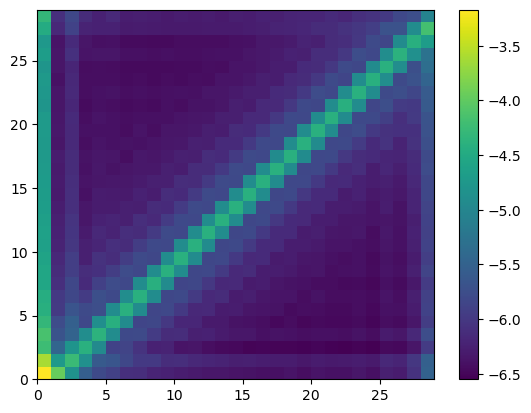

In [303]:
plt.pcolormesh(np.log(delay_mat))
plt.colorbar()

In [273]:
torch.abs(delase.A[area2_inds, :][:, area1_inds]).mean()

tensor(0.0113, device='cuda:0')

In [194]:
# delase_anesthesia_mary = deepcopy(delase)

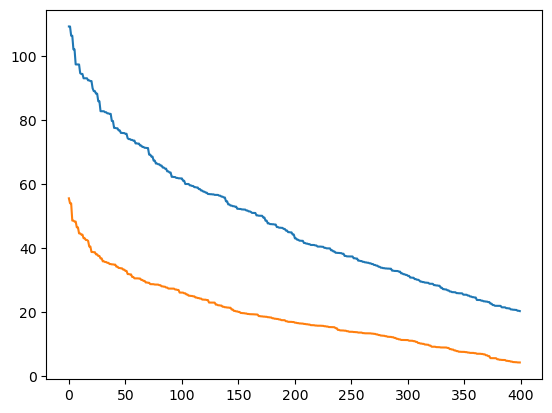

In [262]:
plt.plot(wake_stab[:400])
plt.plot(anesthesia_stab[:400])

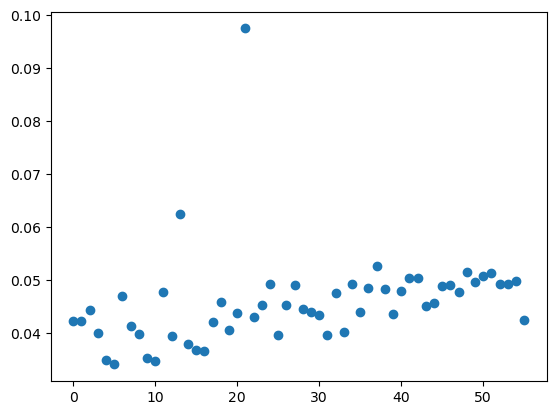

In [158]:
plt.scatter(np.arange(data.shape[1]), data.std(axis=0))

In [161]:
np.argsort(data.std(axis=0))

array([ 5, 10,  4,  9, 16, 15, 14, 12, 31, 25,  8,  3, 33, 19,  7, 17,  1,
        0, 55, 22, 30, 39, 20, 35, 29,  2, 28, 43, 26, 23, 44, 18,  6, 32,
       11, 47, 40, 38, 36, 45, 27, 46, 53, 34, 24, 52, 49, 54, 42, 41, 50,
       51, 48, 37, 13, 21])

In [160]:
np.argsort(data.mean(axis=0))

array([21, 20, 11, 52,  2, 50, 15, 49, 12, 17, 45, 19, 37, 43, 14, 51, 42,
       26,  9, 41,  4, 33,  3,  1,  0, 47, 48, 40, 38, 54, 32, 18,  6,  5,
       27, 53,  7, 10, 34, 16, 46, 55, 24, 35, 36,  8, 25, 22, 39, 30, 44,
       13, 23, 31, 29, 28])

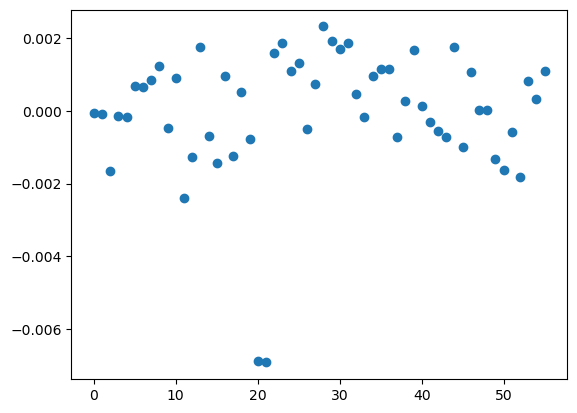

In [159]:
plt.scatter(np.arange(data.shape[1]), data.mean(axis=0))

In [130]:
delase.r

tensor(4409, device='cuda:0')

In [131]:
delase_anesthesia_mary.r

tensor(3767, device='cuda:0')

In [107]:
torch.sum(delase_anesthesia_mary.S.cpu() >= 0.3)

tensor(3767)

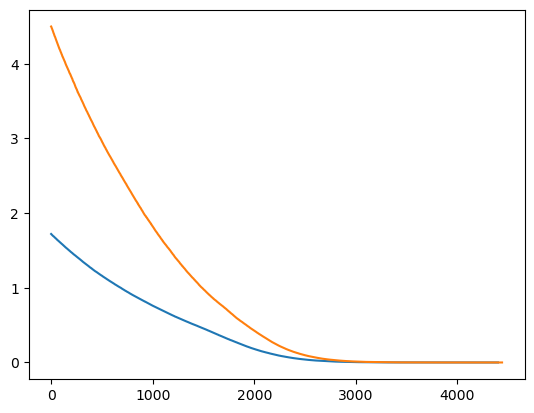

In [108]:
plt.plot(delase_anesthesia_mary.S.cpu()[2000:])
plt.plot(delase.S.cpu()[2000:])

In [211]:
%%time
i = 1000
# i = 480
data = load_window_from_chunks(i, i + 20, directory)
delase = DeLASE(data[:window], 27, use_torch=True, device='cuda')
delase.compute_havok_dmd(r_thresh=r_thresh, lamb=lamb)
delase.dt = dt
test_data = data[window:window + 5000]
ip_ret = compute_integrated_performance(delase, test_data, full_return=True, verbose=True)
delase.compute_jacobians()
delase.get_stability(max_freq=500)

wake_all_ip_ret = ip_ret
wake_all_stab = delase.stability_params.cpu()

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 2min 49s, sys: 34.6 s, total: 3min 24s
Wall time: 2min 28s


In [212]:
%%time
i = 5000
# i = 480
data = load_window_from_chunks(i, i + 20, directory)
delase = DeLASE(data[:window], 27, use_torch=True, device='cuda')
delase.compute_havok_dmd(r_thresh=r_thresh, lamb=lamb)
delase.dt = dt
test_data = data[window:window + 5000]
ip_ret = compute_integrated_performance(delase, test_data, full_return=True, verbose=True)
delase.compute_jacobians()
delase.get_stability(max_freq=500)

anesthesia_all_ip_ret = ip_ret
anesthesia_all_stab = delase.stability_params.cpu()

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 2min 42s, sys: 32.1 s, total: 3min 14s
Wall time: 2min 19s


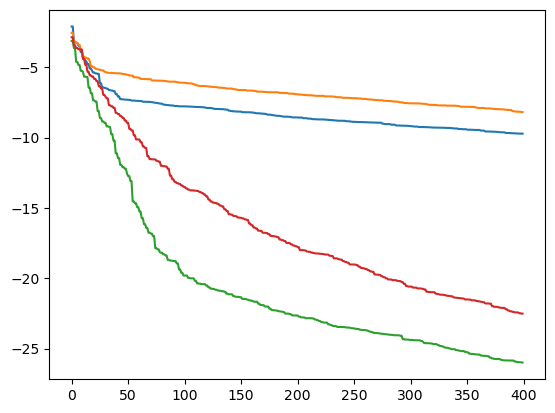

In [215]:
plt.plot(wake_stab[:400])
plt.plot(anesthesia_stab[:400])
plt.plot(wake_all_stab[:400])
plt.plot(anesthesia_all_stab[:400])

# Fixing

In [497]:
for session in os.listdir(results_dir):
# for session in [session]:
    session_results[session] = None
    norm_folder = "NOT_NORMED" if not norm else "NORMED"
    for area in os.listdir(os.path.join(results_dir, session, norm_folder)):
        for f in os.listdir(os.path.join(results_dir, session, norm_folder, area)):
            t = float(f.split('_')[0])
            file_path = os.path.join(results_dir, session, norm_folder, area, f)
            df = pd.DataFrame(pd.read_pickle(file_path))
            if np.isnan(df.ip).sum() > 0:
                print(file_path)
            if 'matrix_size' not in df.columns:
                df['matrix_size'] = 6400
            if session_results[session] is None:
#                 session_results[session] = df[['window', 'p', 'r_thresh', 'lamb', 'ip']]
                session_results[session] = df[['window', 'matrix_size', 'r_thresh', 'lamb', 'ip']]
#                 session_results[session] = session_results[session].set_index(['window', 'p', 'r_thresh', 'lamb'])
                session_results[session] = session_results[session].set_index(['window', 'matrix_size', 'r_thresh', 'lamb'])
                session_results[session]['count'] = 1
                session_results[session]['ip_list'] = session_results[session].ip.apply(lambda x: [x])
                session_results[session]['file_list'] = [file_path]*len(df)
                session_results[session]['file_list'] = session_results[session]['file_list'].apply(lambda x: [x])
            else:
#                 df = df.set_index(['window', 'p', 'r_thresh', 'lamb'])
                df = df.set_index(['window', 'matrix_size', 'r_thresh', 'lamb'])
                for i in range(len(df)):
                    index_val = df.index[i]
                    row = df[['ip']].iloc[i]
                    if index_val in session_results[session].index:
                        session_results[session].loc[index_val, 'ip'] += row.ip
                        session_results[session].loc[index_val, 'count'] += 1
                        session_results[session].loc[index_val, 'ip_list'].append(row.ip)
                        session_results[session].loc[index_val, 'file_list'].append(file_path)
                    else:
                        session_results[session] = pd.concat([session_results[session], df[['ip']].iloc[i:i+1]])
                        session_results[session].loc[index_val, 'count'] = 1
                        session_results[session].loc[index_val, 'ip_list'] = [row.ip]
                        session_results[session].loc[index_val, 'file_list'] = [file_path]
    session_results[session].ip = session_results[session].ip/session_results[session]['count']
    window, matrix_size, r_thresh, lamb = session_results[session].ip.idxmax()
    session_results[session] = dict(
        df=session_results[session],
        window=window,
        matrix_size=matrix_size,
        r_thresh=r_thresh,
        lamb=lamb
    )
    
    if len(session_results[session]['df']) == 1:
        print(session)

NotADirectoryError: [Errno 20] Not a directory: '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results/MrJones-Anesthesia-20160121-01/NOT_NORMED/8340.518_window_15000_matrix_size_6400'

In [488]:
print(session)

Mary-Anesthesia-20160912-02


In [489]:
print(area)

NORMED
